Этап 1. Загрузка и предобработка данных

In [12]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import torch

# Трансформации для датасетов
train_transforms = Compose([
    RandomHorizontalFlip(p=0.2),
    RandomVerticalFlip(p=0.2),
    RandomRotation([-5, 5], fill=255.),
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

# Класс-обёртка для трансформаций
class TransformDataset(Dataset):
  def __init__(self, dataset, transforms):
    super(TransformDataset, self).__init__()
    self.dataset = dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset[idx]
    return self.transforms(x), y
    

# Загрузка датасета
dataset_path = 'dataset/ogyeiv2/train'
dataset = ImageFolder(dataset_path)


# Добавление трансформаций к датасетам
train_dataset = ImageFolder("dataset/ogyeiv2/train", transform=train_transforms)
test_dataset = ImageFolder("dataset/ogyeiv2/test", transform=test_transforms)

# Упаковка для обучения в DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Проверка
num_classes = len(train_dataset.classes)
print(f"Количество классов в train: {num_classes}")
print("Количество изображений в train:", len(train_dataset))
print("Количество изображений в val:", len(test_dataset))
print("Список классов:", dataset.classes)

Количество классов в train: 84
Количество изображений в train: 2352
Количество изображений в val: 504
Список классов: ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg', 'atorvastatin_teva_20_mg', 'betaloc_50_mg', 'bila_git', 'c_vitamin_teva_500_mg', 'calci_kid', 'cataflam_50_mg', 'cataflam_dolo_25_mg', 'cetirizin_10_mg', 'cold_fx', 'coldrex', 'concor_10_mg', 'concor_5_mg', 'condrosulf_800_mg', 'controloc_20_mg', 'covercard_plus_10_mg_2_5_mg_5_mg', 'coverex_4_mg', 'diclopram_75-mg_20-mg', 'dorithricin_mentol', 'dulsevia_60_mg', 'enterol_250_mg', 'favipiravir_meditop_200_mg', 'ibumax_400_mg', 'jutavit_c_vitamin', 'jutavit_cink', 'kalcium_magnezium_cink', 'kalium_r', 'koleszterin_kontroll', 'lactamed', 'lactiv_plus', 'laresin_10_mg', 'letrox_50_mikrogramm', 'lordestin_5_mg', 'merckformin_xr_1000_mg', 'meridian', 'metothyrin_10_m

Этап 2. Объявление предобученной модели

In [13]:
from torchsummary import summary
from torchvision.models import mobilenet_v3_small
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используется:", device)
# Загрузка модели
model = mobilenet_v3_small(weights='IMAGENET1K_V1')

# Замена слоя для классификации
model.classifier = nn.Linear(in_features=576, out_features=84, bias=True) # type: ignore

# Заморозка слоёв
for param in model.parameters():
    param.requires_grad = False

# Разморозка полносвязного слоя classifier
for param in model.classifier.parameters():
    param.requires_grad = True
    
# Проверка
#summary(model, input_size=(3, 224, 224), device='cpu') 

Используется: cuda


Этап 3. Дообучение модели

In [17]:
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)   
print(device)
# Настройка гиперпараметров
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10
best_vloss = 1e5

# Код обучения из прошлого урока
def train_one_epoch(epoch_index):
    running_loss = 0.0
    last_loss = 0.0

    for batch_index, data in enumerate(train_loader):
        # Извлечение батча
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямое распространение
        outputs = model(inputs)
        # Подсчёт ошибки
        loss = criterion(outputs, labels)
        # Обратное распространение
        loss.backward()
        # Обновление весов
        optimizer.step()

        # Суммирование ошибки за последние 20 батчей
        running_loss += loss.item()
        if batch_index % 20 == 19:
            last_loss = running_loss / 20. # средняя ошибка за 20 батчей
            print(f'Эпоха: {epoch_index}, батч: {batch_index}, ошибка {last_loss}')
            running_loss = 0.0

    return last_loss

for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')
    
    # Перевод модели в режим обучения
    model.train(True)
    # Эпоха обучения
    avg_loss = train_one_epoch(epoch)

    # Перевод модели в режим валидации
    model.eval()
    running_vloss = 0.0

    # Валидация
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1) # type: ignore

    # Сохранение лучшей модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_save/meds_classifier.pt_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'В конце эпохи ошибка train {avg_loss}, ошибка val {avg_vloss}')
    

cuda
Эпоха 0
Эпоха: 0, батч: 19, ошибка 1.6328492999076842
Эпоха: 0, батч: 39, ошибка 1.5193487346172332
Эпоха: 0, батч: 59, ошибка 1.494028276205063
В конце эпохи ошибка train 1.494028276205063, ошибка val 1.443057656288147
Эпоха 1
Эпоха: 1, батч: 19, ошибка 1.408991414308548
Эпоха: 1, батч: 39, ошибка 1.4396265745162964
Эпоха: 1, батч: 59, ошибка 1.3935723185539246
В конце эпохи ошибка train 1.3935723185539246, ошибка val 1.2523449659347534
Эпоха 2
Эпоха: 2, батч: 19, ошибка 1.3179976999759675
Эпоха: 2, батч: 39, ошибка 1.3352862626314164
Эпоха: 2, батч: 59, ошибка 1.2495826214551926
В конце эпохи ошибка train 1.2495826214551926, ошибка val 1.1440309286117554
Эпоха 3
Эпоха: 3, батч: 19, ошибка 1.3189789235591889
Эпоха: 3, батч: 39, ошибка 1.2137344002723693
Эпоха: 3, батч: 59, ошибка 1.246394544839859
В конце эпохи ошибка train 1.246394544839859, ошибка val 1.084438681602478
Эпоха 4
Эпоха: 4, батч: 19, ошибка 1.218596863746643
Эпоха: 4, батч: 39, ошибка 1.192993438243866
Эпоха: 4, ба

Этап 4. Оценка качества

5 худших классов по F1:
teva_enterobene_2_mg: 0.25
sicor_10_mg: 0.29
covercard_plus_10_mg_2_5_mg_5_mg: 0.40
teva_ambrobene_30_mg: 0.40
rubophen_500_mg: 0.50

5 лучших классов по F1:
salazopyrin_en_500_mg: 1.00
strepfen_8_75_mg: 1.00
valeriana_teva: 1.00
vita_c: 1.00
xeter_20_mg: 1.00
                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       1.00      1.00      1.00         6
      algoflex_forte_dolo_400_mg       1.00      0.83      0.91         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         6
                algopyrin_500_mg       1.00      0.83      0.91         6
             ambroxol_egis_30_mg       1.00      1.00      1.00         6
                  apranax_550_mg       0.86      1.00      0.92         6
            aspirin_ultra_500_mg       1.00     

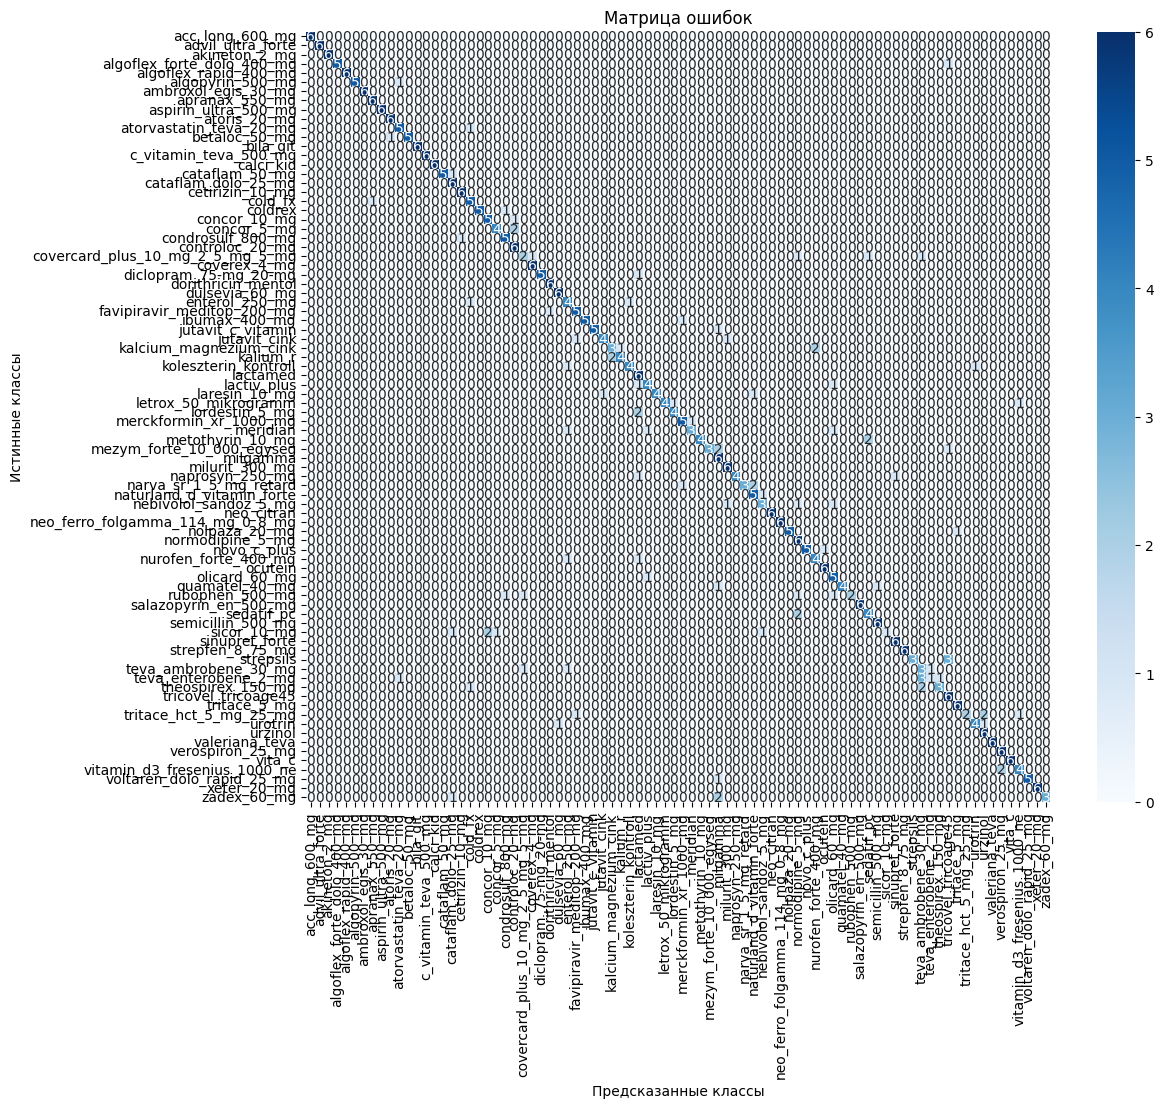

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

model.to('cpu') 

labels_predicted = []
labels_true = []

model.load_state_dict(torch.load("model_save/meds_classifier.pt_9.pt", weights_only=True))
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.numpy())
        labels_true.extend(labels.numpy())

report = classification_report(
    labels_true,
    labels_predicted,
    target_names=dataset.classes,
    output_dict=True
)

class_scores = {cls: report[cls]["f1-score"] for cls in dataset.classes} # type: ignore

sorted_scores = sorted(class_scores.items(), key=lambda x: x[1])

print("5 худших классов по F1:")
for cls, score in sorted_scores[:5]:
    print(f"{cls}: {score:.2f}")

print("\n5 лучших классов по F1:")
for cls, score in sorted_scores[-5:]:
    print(f"{cls}: {score:.2f}")

print(classification_report(labels_true, labels_predicted, target_names=dataset.classes))

cm = confusion_matrix(labels_true, labels_predicted)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)

plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()